# Global Terrorism Database

## Introduction
The aim of this analysis is to provide answers to the following questions:

- How has the number of terrorist activities changed over the years?
- Are there certain regions where this trend is different from the global averages?
- How often the attack becomes a success?
- What are the most common methods of attacks? Does it differ in various regions or in time?

## About the dataset
The Dataset was extracted from the Global Terrorism Database (GTD) - an open-source database including information on terrorist attacks around the world from 1970 through 2017. The GTD includes systematic data on domestic as well as international terrorist incidents that have occurred during this time period and now includes more than 180,000 attacks.

## Explanation of selected columns:
- success - Success of a terrorist strike
- suicide - 1 = "Yes" The incident was a suicide attack. 0 = "No" There is no indication that the incident was a suicide
- attacktype1 - The general method of attack
- attacktype1_txt - The general method of attack and broad class of tactics used.
- targtype1_txt - The general type of target/victim
- targsubtype1_txt - The more specific target category
- target1 - The specific person, building, installation that was targeted and/or victimized
- natlty1_txt - The nationality of the target that was attacked
- gname - The name of the group that carried out the attack
- gsubname - Additional details about group that carried out the attack like fractions
- nperps - The total number of terrorists participating in the incident
- weaptype1_txt - General type of weapon used in the incident
- weapsubtype1_txt - More specific value for most of the Weapon Types
- nkill - The number of total confirmed fatalities for the incident
- nkillus - The number of U.S. citizens who died as a result of the incident

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, classification_report, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier

from sklearn.pipeline import make_pipeline

In [4]:
data1 = pd.read_csv('../gtd_data/globalterrorismdb_1.csv')
data_2021 = pd.read_csv('../gtd_data/globalterrorismdb_2021Jan-June_1222dist.csv')

In [6]:
data = pd.concat([data1, data_2021], ignore_index=True)

In [7]:
data.shape

(214666, 135)

In [11]:
# After combining the Data till 2021, We now have a total of 214666 rows and 135 columns

In [13]:
data.head()

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,4,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN


In [15]:
print('Number of Variables in dataset: ', data.shape[1])

Number of Variables in dataset:  135


In [17]:
print('Number of records in dataset: ', data.shape[0])

Number of records in dataset:  214666


In [19]:
data.columns.values

array(['eventid', 'iyear', 'imonth', 'iday', 'approxdate', 'extended',
       'resolution', 'country', 'country_txt', 'region', 'region_txt',
       'provstate', 'city', 'latitude', 'longitude', 'specificity',
       'vicinity', 'location', 'summary', 'crit1', 'crit2', 'crit3',
       'doubtterr', 'alternative', 'alternative_txt', 'multiple',
       'success', 'suicide', 'attacktype1', 'attacktype1_txt',
       'attacktype2', 'attacktype2_txt', 'attacktype3', 'attacktype3_txt',
       'targtype1', 'targtype1_txt', 'targsubtype1', 'targsubtype1_txt',
       'corp1', 'target1', 'natlty1', 'natlty1_txt', 'targtype2',
       'targtype2_txt', 'targsubtype2', 'targsubtype2_txt', 'corp2',
       'target2', 'natlty2', 'natlty2_txt', 'targtype3', 'targtype3_txt',
       'targsubtype3', 'targsubtype3_txt', 'corp3', 'target3', 'natlty3',
       'natlty3_txt', 'gname', 'gsubname', 'gname2', 'gsubname2',
       'gname3', 'gsubname3', 'motive', 'guncertain1', 'guncertain2',
       'guncertain3', 'in

# Exploratory Data Analysis

## Data Exploration

### 1. Number of Terrorist Attacks per year

In [24]:
# Attacks per Year in whole world
attacks_per_year = data['iyear'].value_counts().sort_index()

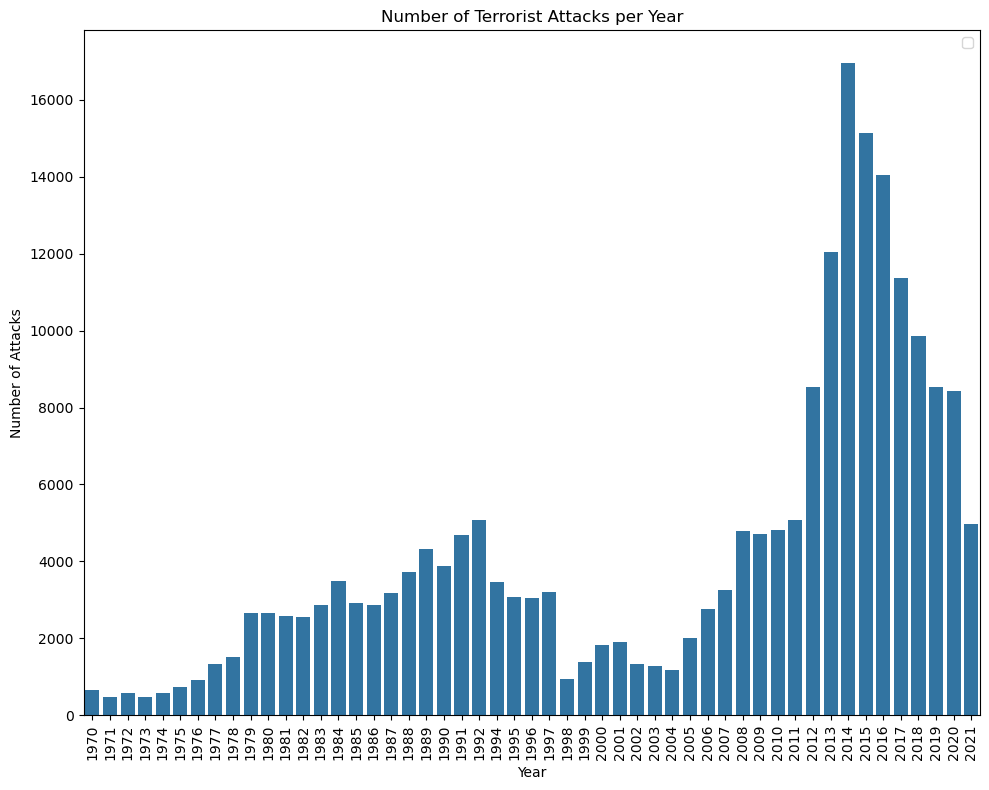

In [26]:
plt.figure(figsize=(10, 8))
sns.countplot(data, x='iyear')
plt.title('Number of Terrorist Attacks per Year')
plt.xlabel('Year')
plt.ylabel('Number of Attacks')
plt.xticks(rotation=90)
plt.tight_layout()
plt.legend()
plt.savefig("attacks_per_year.png", dpi=300, bbox_inches='tight')  # Save high-resolution image
plt.show()

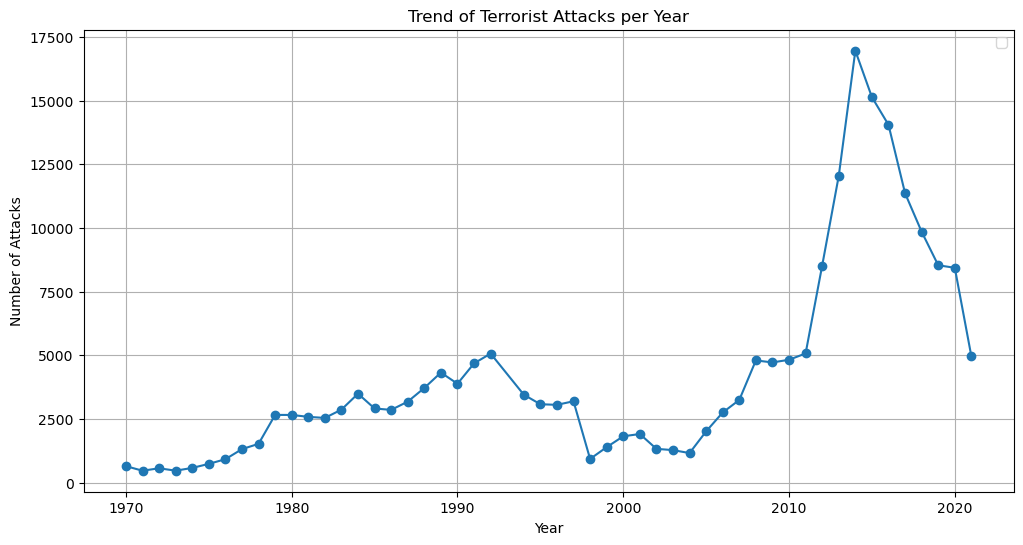

In [27]:
# Trend of Terrorist Attacks every Year
plt.figure(figsize=(12, 6))
plt.plot(attacks_per_year.index, attacks_per_year.values, marker='o', linestyle='-')
plt.title('Trend of Terrorist Attacks per Year')
plt.xlabel('Year')
plt.ylabel('Number of Attacks')
plt.grid(True)
plt.legend()
plt.savefig("attacks_per_year_Trend.png", dpi=300, bbox_inches='tight')  # Save high-resolution image
plt.show()

### Different type of Attack Types

In [31]:
attack_types = data['attacktype1_txt'].value_counts().sort_values(ascending=False)
attack_types

attacktype1_txt
Bombing/Explosion                      99986
Armed Assault                          50845
Assassination                          21989
Hostage Taking (Kidnapping)            14493
Facility/Infrastructure Attack         12606
Unknown                                11545
Unarmed Assault                         1257
Hostage Taking (Barricade Incident)     1172
Hijacking                                773
Name: count, dtype: int64

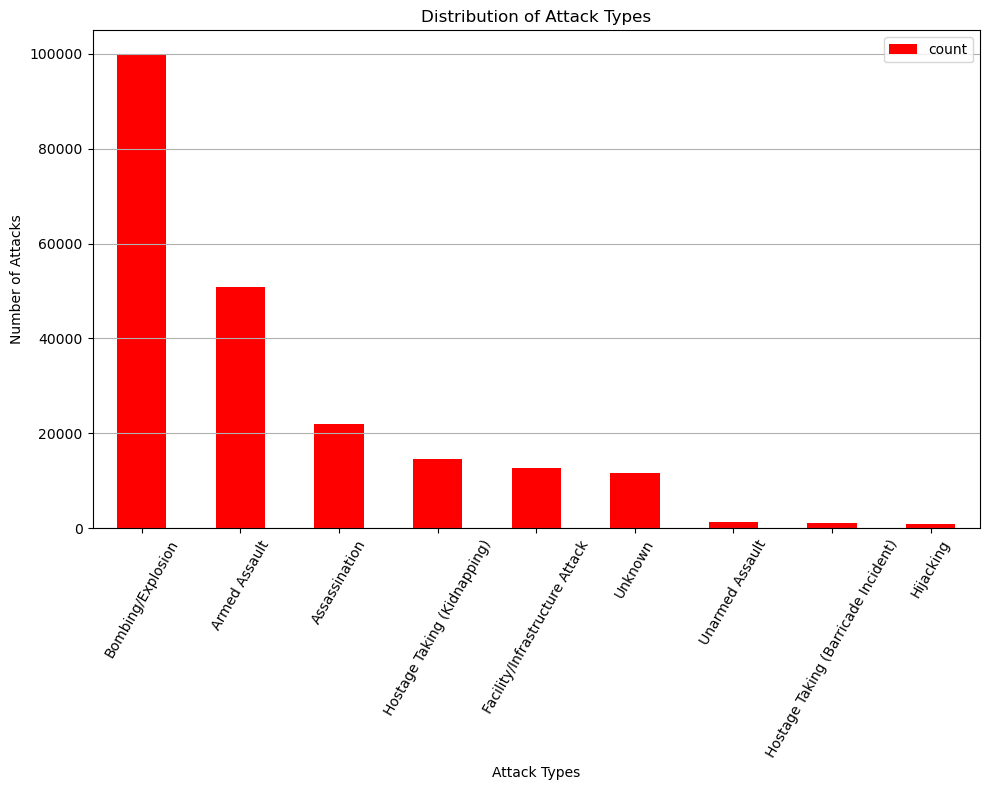

In [33]:
plt.figure(figsize=(10, 8))
attack_types.plot(kind='bar', color='red')
plt.title('Distribution of Attack Types')
plt.xlabel('Attack Types')
plt.ylabel('Number of Attacks')
plt.xticks(rotation=60)
plt.grid(axis='y')
plt.tight_layout()
plt.legend()
plt.savefig("Attack_types_frequency.png", dpi=300, bbox_inches='tight')
plt.show()

### Number of Attacks by Country

In [36]:
attacks_by_country = data['country_txt'].value_counts().sort_values(ascending=False)
attacks_by_country.head(15)

country_txt
Iraq              28068
Afghanistan       20373
Pakistan          15654
India             14164
Colombia           8991
Philippines        8375
Yemen              6317
Peru               6116
Nigeria            5998
United Kingdom     5553
Somalia            5442
El Salvador        5321
Turkey             4499
Thailand           4228
Spain              3257
Name: count, dtype: int64

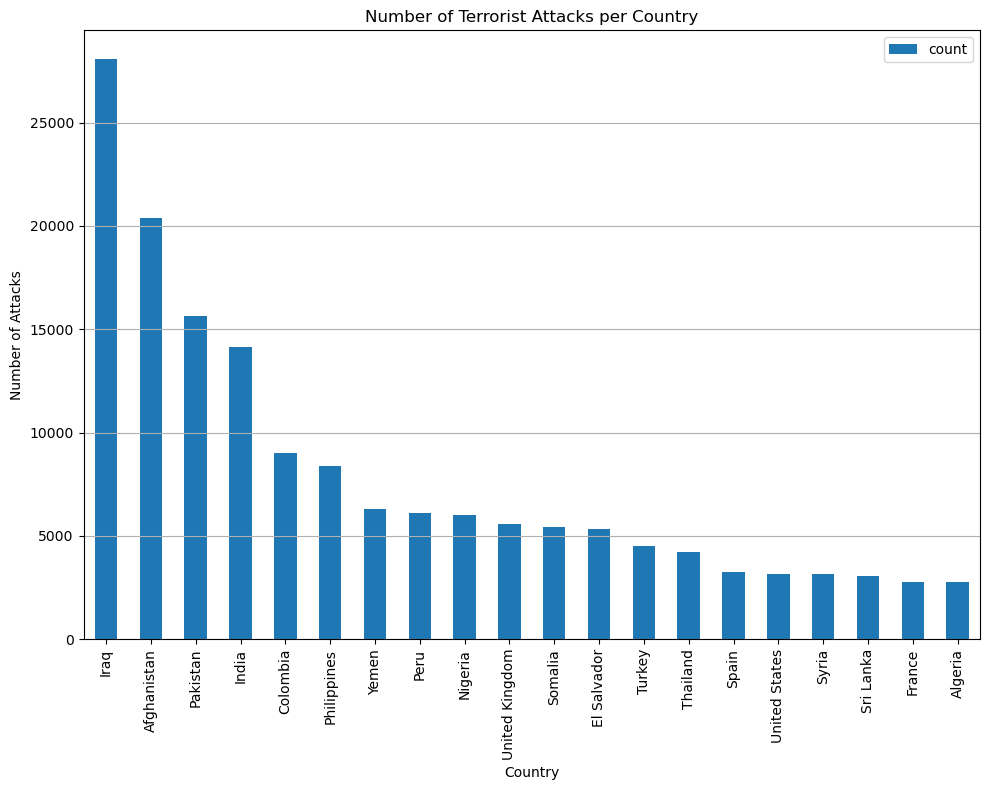

In [39]:
# Number of Terrorist Attacks per country
plt.figure(figsize=(10, 8))
attacks_by_country.head(20).plot(kind='bar')
plt.title('Number of Terrorist Attacks per Country')
plt.xlabel('Country')
plt.ylabel('Number of Attacks')
plt.grid(axis='y')
plt.tight_layout()
plt.legend()
plt.savefig("Attacks_per_country.png", dpi=300, bbox_inches='tight')
plt.show()

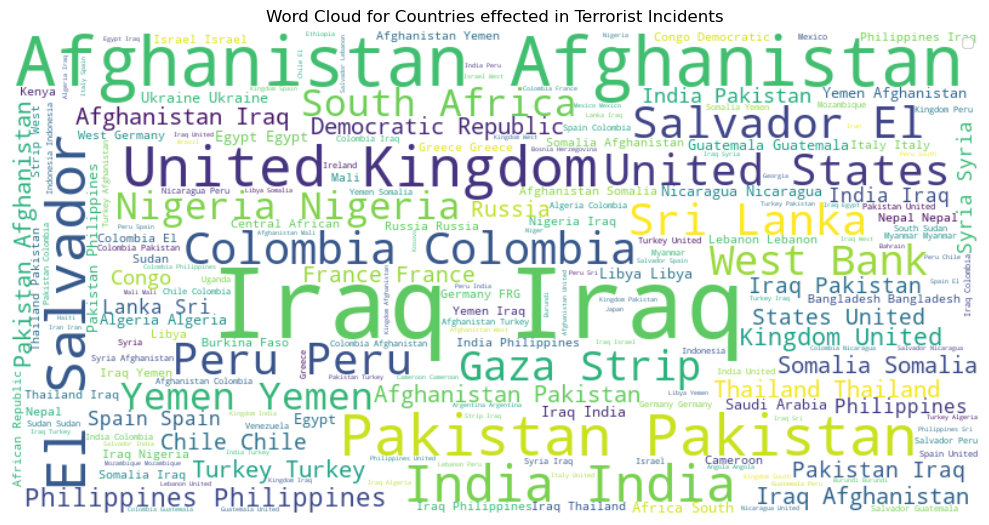

In [40]:
from wordcloud import WordCloud
countries_effected = data['country_txt'].dropna()

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(countries_effected))

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Countries effected in Terrorist Incidents')
plt.axis('off')
plt.tight_layout()
plt.legend()
plt.savefig("CountryEffected_wordCloud.png", dpi=300, bbox_inches='tight')
plt.show()

## Disrtribution of Target Types

In [45]:
target_types = data['targtype1_txt'].value_counts().sort_values(ascending=False)
target_types.head(10)

targtype1_txt
Private Citizens & Property       53487
Military                          35292
Police                            29236
Government (General)              24355
Business                          22412
Unknown                            7351
Transportation                     7241
Utilities                          6424
Religious Figures/Institutions     5191
Educational Institution            4836
Name: count, dtype: int64

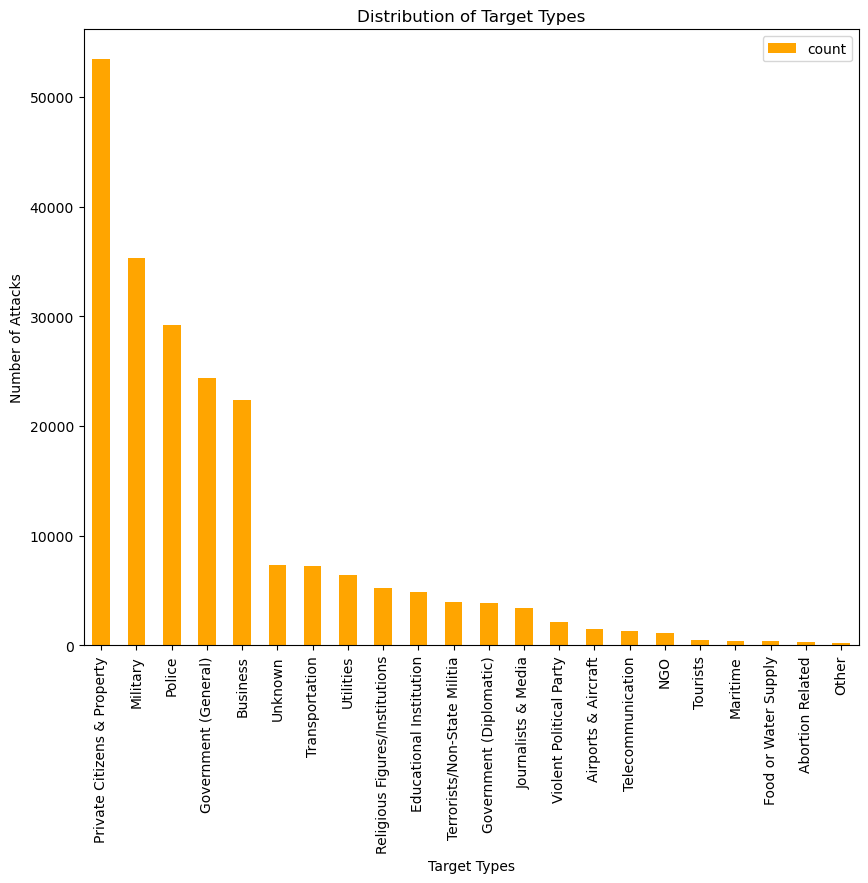

In [47]:
plt.figure(figsize=(10, 8))
target_types.plot(kind='bar', color='orange')
plt.title('Distribution of Target Types')
plt.xlabel('Target Types')
plt.ylabel('Number of Attacks')
plt.xticks(rotation=90)
plt.legend()
# plt.savefig("TargetType_Distribution.png", dpi=300, bbox_inches='tight')
plt.show()

## Bivariate Analysis

### Number of people killed by Country

In [52]:
casualties_per_year = data.groupby('iyear')['nkill'].count().sort_index()
casualties_per_year

iyear
1970      609
1971      407
1972      523
1973      424
1974      523
1975      587
1976      814
1977     1191
1978     1373
1979     2257
1980     2210
1981     1928
1982     1741
1983     1974
1984     2805
1985     2474
1986     2481
1987     3089
1988     3688
1989     4290
1990     3880
1991     4581
1992     5048
1994     3368
1995     3076
1996     3001
1997     3131
1998      871
1999     1346
2000     1766
2001     1892
2002     1318
2003     1260
2004     1149
2005     1999
2006     2672
2007     3206
2008     4736
2009     4705
2010     4822
2011     5047
2012     8318
2013    11694
2014    15925
2015    14290
2016    13210
2017    10681
2018     9082
2019     7857
2020     7860
2021     4536
Name: nkill, dtype: int64

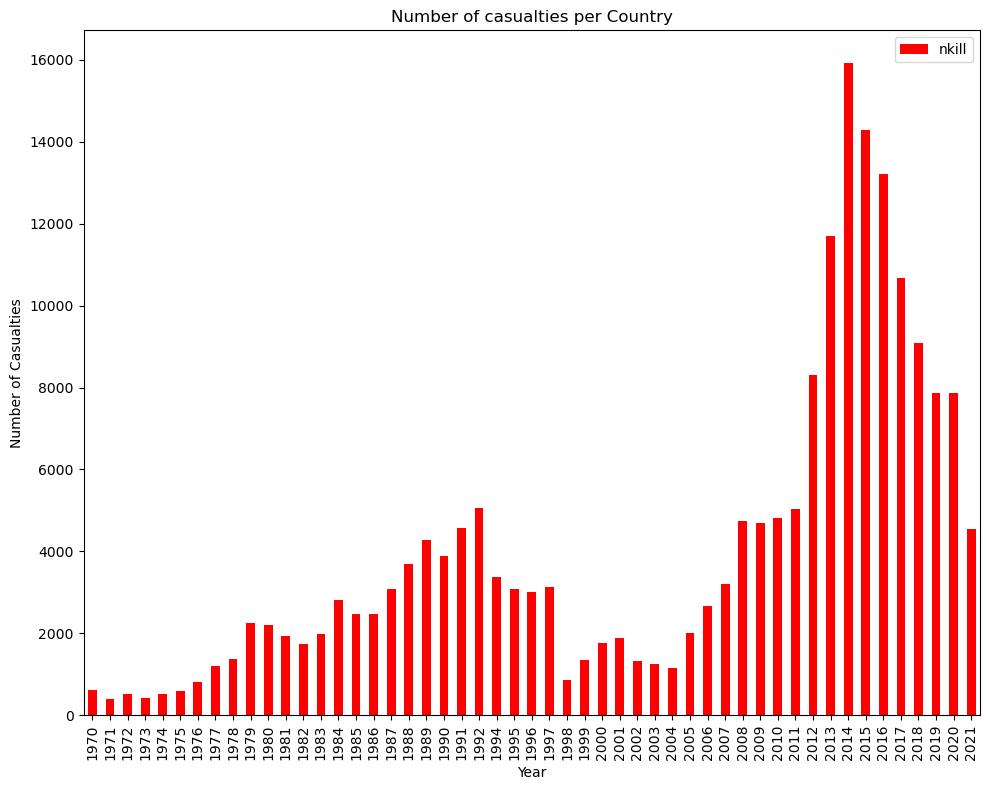

In [54]:
# Number of people killed by country
plt.figure(figsize=(10, 8))
casualties_per_year.plot(kind='bar', color='red')
plt.title('Number of casualties per Country')
plt.xlabel('Year')
plt.ylabel('Number of Casualties')
plt.tight_layout()
plt.legend()
# plt.savefig("Number of people killed by country.png", dpi=300, bbox_inches='tight')
plt.show()

### Number of Casualties by Target_types

In [58]:
casualties_by_attackType = data.groupby('attacktype1_txt')['nkill'].sum().sort_values(ascending=False)
casualties_by_attackType

attacktype1_txt
Armed Assault                          186919.0
Bombing/Explosion                      176655.0
Unknown                                 50934.0
Hostage Taking (Kidnapping)             33694.0
Assassination                           28187.0
Hostage Taking (Barricade Incident)      5102.0
Facility/Infrastructure Attack           4664.0
Hijacking                                3782.0
Unarmed Assault                           956.0
Name: nkill, dtype: float64

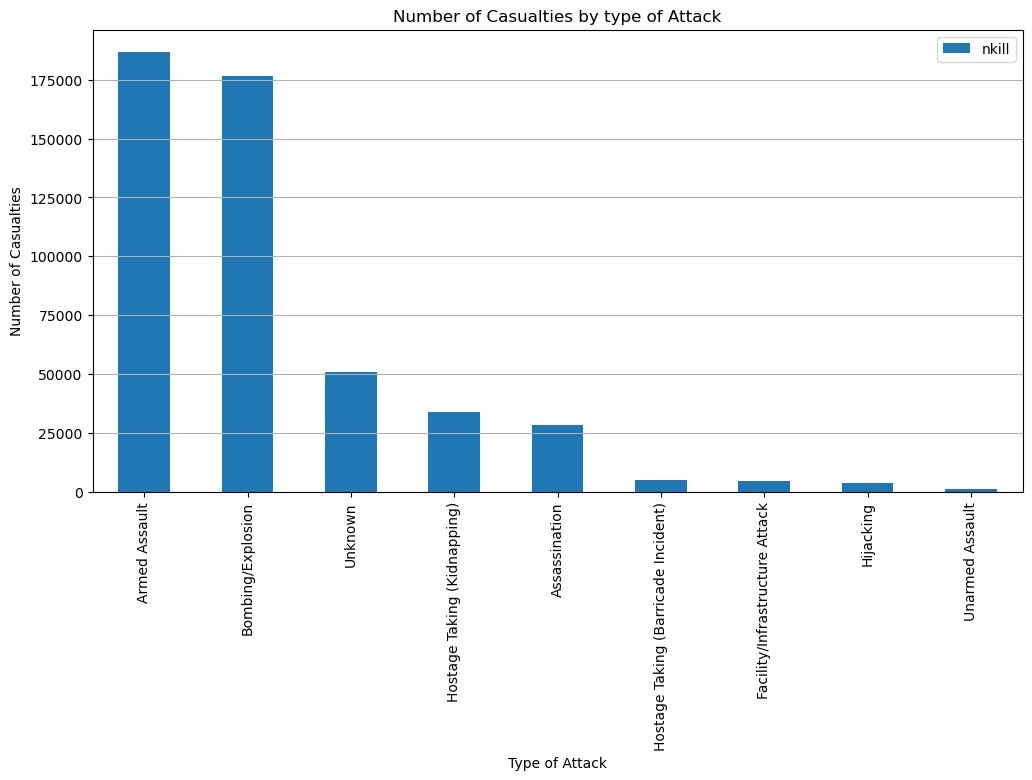

In [60]:
plt.figure(figsize=(12, 6))
casualties_by_attackType.plot(kind='bar')
plt.title('Number of Casualties by type of Attack')
plt.xlabel('Type of Attack')
plt.ylabel('Number of Casualties')
plt.grid(axis='y')
plt.legend()
# plt.savefig("Number_of_casualties_by_attackType.png", dpi=300, bbox_inches='tight')
plt.show()

### Top Terrorist Groups by Casualties

In [63]:
top_terrorist_groups = data.groupby('gname')[['nkill', 'nwound']].sum().sort_values(by='nkill', ascending=False)
top_terrorist_groups

,nkill,nwound
gname,,
Unknown,122086.0,222785.0
Taliban,57650.0,47704.0
Islamic State of Iraq and the Levant (ISIL),43688.0,35182.0
Boko Haram,26339.0,12204.0
Al-Shabaab,12740.0,10215.0
...,...,...
Niger Delta Freedom Fighters (NDDF),0.0,0.0
Niger Delta Forest Army (NDFA),0.0,0.0
Cuban Secret Army,0.0,0.0


<Figure size 1200x800 with 0 Axes>

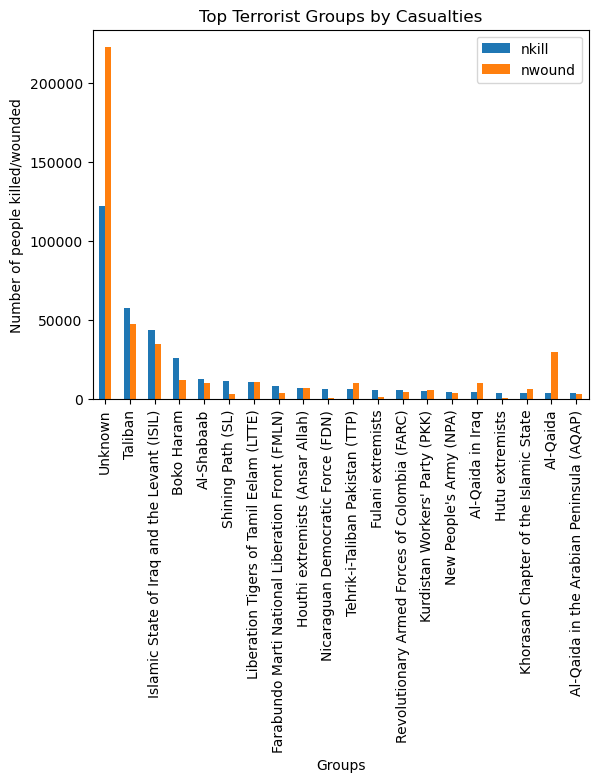

In [65]:
plt.figure(figsize=(12, 8))
top_terrorist_groups.head(20).plot(kind='bar')
plt.title('Top Terrorist Groups by Casualties')
plt.xlabel('Groups')
plt.ylabel('Number of people killed/wounded')
plt.xticks(rotation=90)
plt.legend()
# plt.savefig("Top_terrorist_groups_by_casualties.png", dpi=300, bbox_inches='tight')
plt.show()

## Summarising EDA

### 1. Top 5 Terrorist Groups (number of Attacks)

In [70]:
groups = data[data['gname'] != 'Unknown']
groups.head()

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
5,197001010002,1970,1,1,NaN,0,NaN,217,United States,1,...,"The Cairo Chief of Police, William Petersen, r...","""Police Chief Quits,"" Washington Post, January...","""Cairo Police Chief Quits; Decries Local 'Mili...","Christopher Hewitt, ""Political Violence and Te...",Hewitt Project,-9,-9,0,-9,NaN
6,197001020001,1970,1,2,NaN,0,NaN,218,Uruguay,3,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
8,197001020003,1970,1,2,NaN,0,NaN,217,United States,1,...,The New Years Gang issue a communiqué to a loc...,"Tom Bates, ""Rads: The 1970 Bombing of the Army...","David Newman, Sandra Sutherland, and Jon Stewa...","The Wisconsin Cartographers' Guild, ""Wisconsin...",Hewitt Project,0,0,0,0,NaN


In [72]:
top_10_terrorist_groups = (data['gname'].value_counts(normalize=True)*100).sort_values(ascending=False)
top_10_terrorist_groups.head(10)

gname
Unknown                                             43.637558
Taliban                                              6.026106
Islamic State of Iraq and the Levant (ISIL)          3.484017
Shining Path (SL)                                    2.127491
Al-Shabaab                                           2.118174
Houthi extremists (Ansar Allah)                      1.637893
Boko Haram                                           1.611340
New People's Army (NPA)                              1.602955
Farabundo Marti National Liberation Front (FMLN)     1.561030
Irish Republican Army (IRA)                          1.243793
Name: proportion, dtype: float64

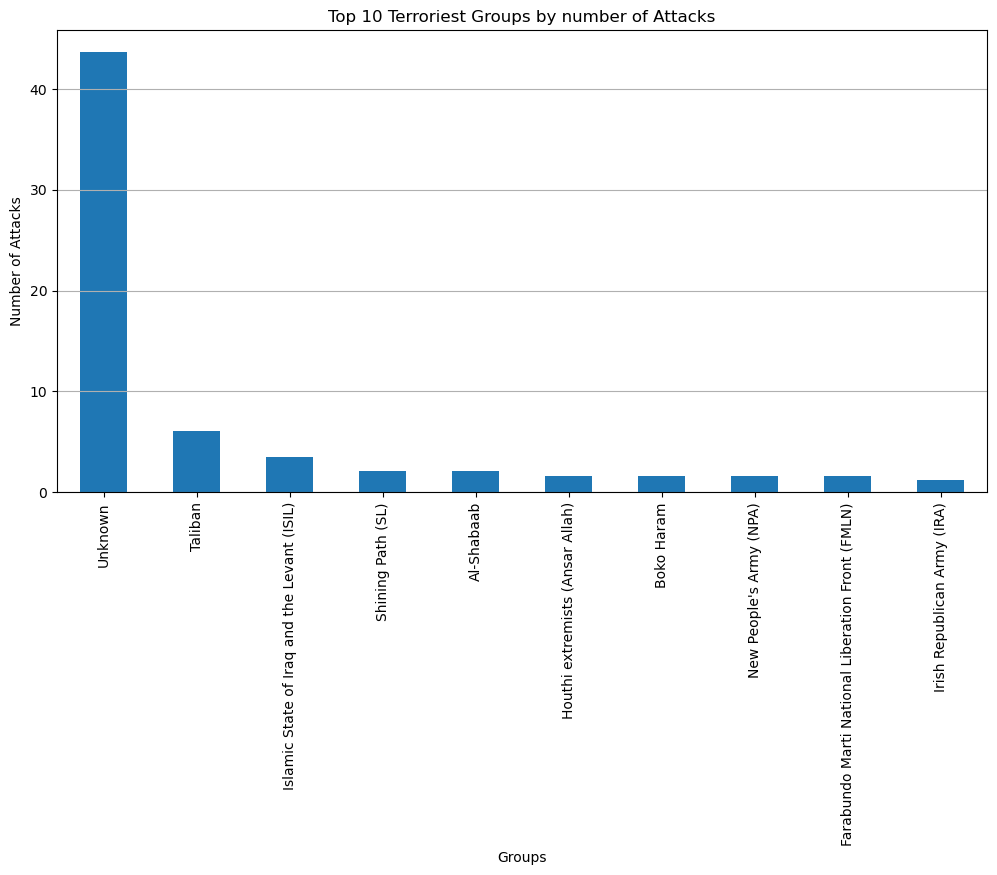

In [74]:
plt.figure(figsize=(12, 6))
top_10_terrorist_groups.head(10).plot(kind='bar')
plt.title('Top 10 Terroriest Groups by number of Attacks')
plt.xlabel('Groups')
plt.ylabel('Number of Attacks')
plt.grid(axis='y')
plt.show()

## 2. Top 10 Countries most affected by Terrorist Attacks

In [77]:
top_10_country = data['country_txt'].value_counts().head(10)
top_10_country

country_txt
Iraq              28068
Afghanistan       20373
Pakistan          15654
India             14164
Colombia           8991
Philippines        8375
Yemen              6317
Peru               6116
Nigeria            5998
United Kingdom     5553
Name: count, dtype: int64

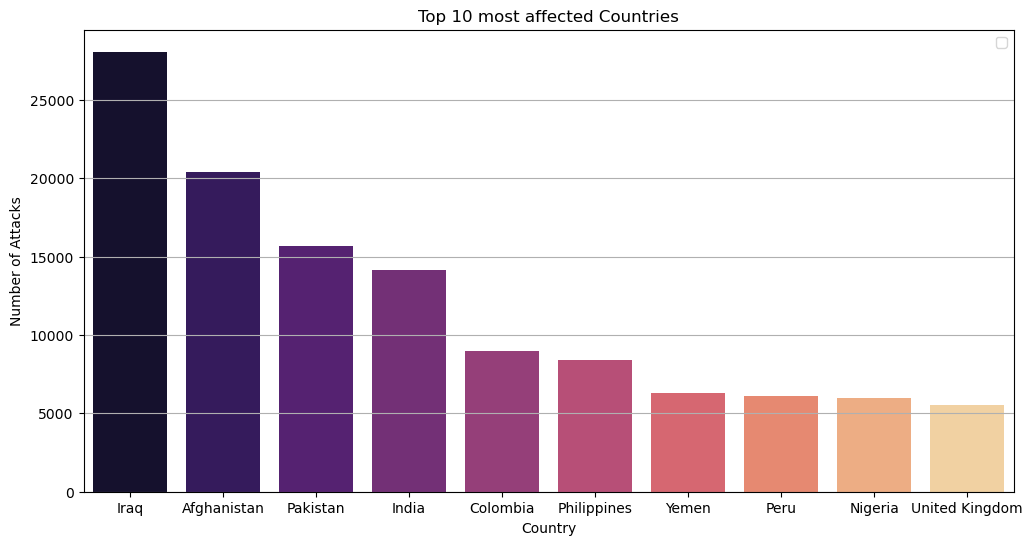

In [79]:
plt.figure(figsize=(12, 6))
# top_10_country.plot(kind='bar')
sns.countplot(data, x='country_txt', order=top_10_country.index, palette='magma')
plt.title('Top 10 most affected Countries')
plt.xlabel('Country')
plt.ylabel('Number of Attacks')
plt.grid(axis='y')
plt.legend()
# plt.savefig("Top10_countries_most_affected.png", dpi=300, bbox_inches='tight')
plt.show()

## 3. Top 10 most common attack types

In [82]:
top_10_attack_types = data['attacktype1_txt'].value_counts().head(10)
top_10_attack_types

attacktype1_txt
Bombing/Explosion                      99986
Armed Assault                          50845
Assassination                          21989
Hostage Taking (Kidnapping)            14493
Facility/Infrastructure Attack         12606
Unknown                                11545
Unarmed Assault                         1257
Hostage Taking (Barricade Incident)     1172
Hijacking                                773
Name: count, dtype: int64

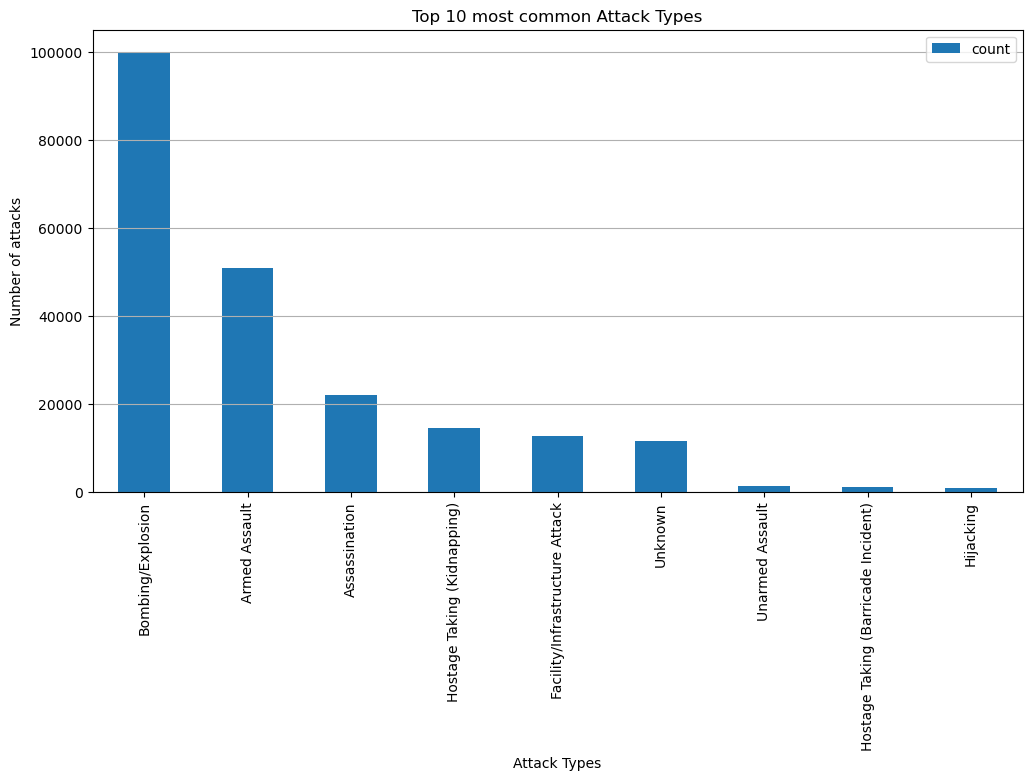

In [84]:
plt.figure(figsize=(12, 6))
top_10_attack_types.plot(kind='bar')
plt.title('Top 10 most common Attack Types')
plt.xlabel('Attack Types')
plt.ylabel('Number of attacks')
plt.grid(axis='y')
plt.legend()
# plt.savefig("Top10_most_common_attackTypes.png", dpi=300, bbox_inches='tight')
plt.show()

## 4. Top 10 most common Target Types

In [87]:
top_10_target_types = data['targtype1_txt'].value_counts().head(10)
top_10_target_types

targtype1_txt
Private Citizens & Property       53487
Military                          35292
Police                            29236
Government (General)              24355
Business                          22412
Unknown                            7351
Transportation                     7241
Utilities                          6424
Religious Figures/Institutions     5191
Educational Institution            4836
Name: count, dtype: int64

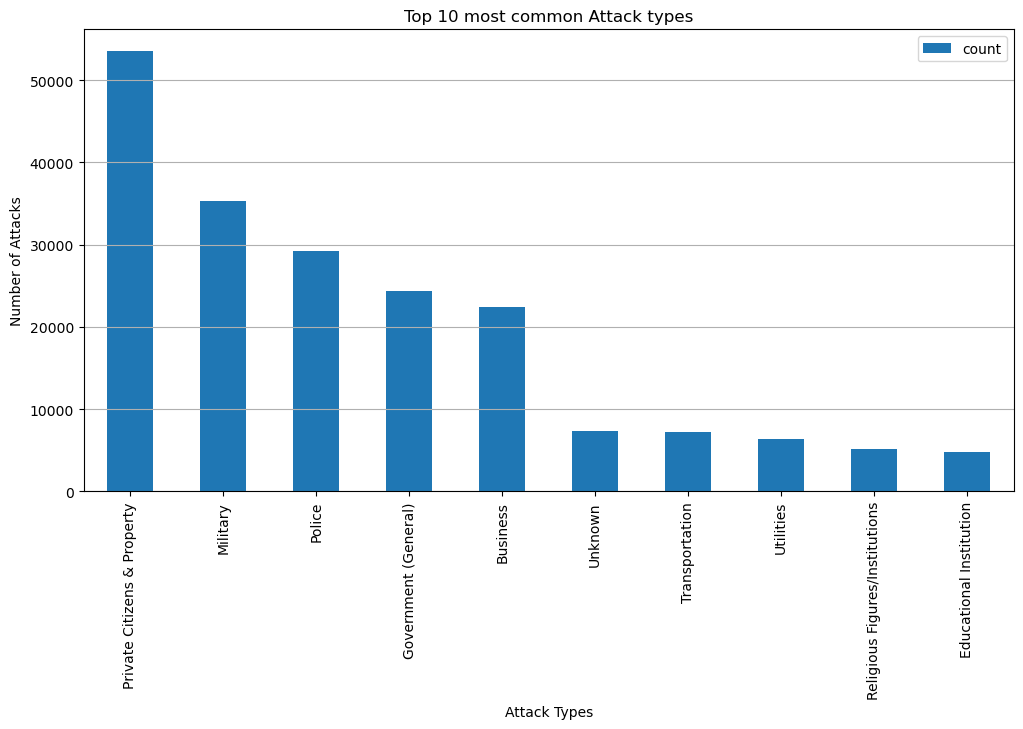

In [89]:
plt.figure(figsize=(12, 6))
top_10_target_types.plot(kind='bar')
plt.title('Top 10 most common Attack types')
plt.xlabel('Attack Types')
plt.ylabel('Number of Attacks')
plt.grid(axis='y')
plt.legend()
# plt.savefig("Top10_most_common_attackTypes.png", dpi=300, bbox_inches='tight')
plt.show()

## 5. Number of Attacks per year

In [92]:
print('Number of Attacks per Year: \n')
print(attacks_per_year)


Number of Attacks per Year: 

iyear
1970      651
1971      471
1972      567
1973      473
1974      581
1975      740
1976      923
1977     1319
1978     1526
1979     2662
1980     2661
1981     2586
1982     2543
1983     2870
1984     3495
1985     2914
1986     2860
1987     3183
1988     3720
1989     4324
1990     3886
1991     4685
1992     5071
1994     3456
1995     3081
1996     3058
1997     3198
1998      934
1999     1396
2000     1823
2001     1912
2002     1330
2003     1280
2004     1164
2005     2017
2006     2757
2007     3250
2008     4801
2009     4723
2010     4827
2011     5075
2012     8525
2013    12047
2014    16960
2015    15138
2016    14051
2017    11364
2018     9853
2019     8537
2020     8438
2021     4960
Name: count, dtype: int64


## 6. Most 10 most affected Regions of the World

In [96]:
top_10_region = data['region_txt'].value_counts().head(10)
top_10_region

region_txt
Middle East & North Africa     59514
South Asia                     56578
Sub-Saharan Africa             24883
South America                  19993
Western Europe                 17433
Southeast Asia                 14871
Central America & Caribbean    10388
Eastern Europe                  5342
North America                   3906
East Asia                        852
Name: count, dtype: int64

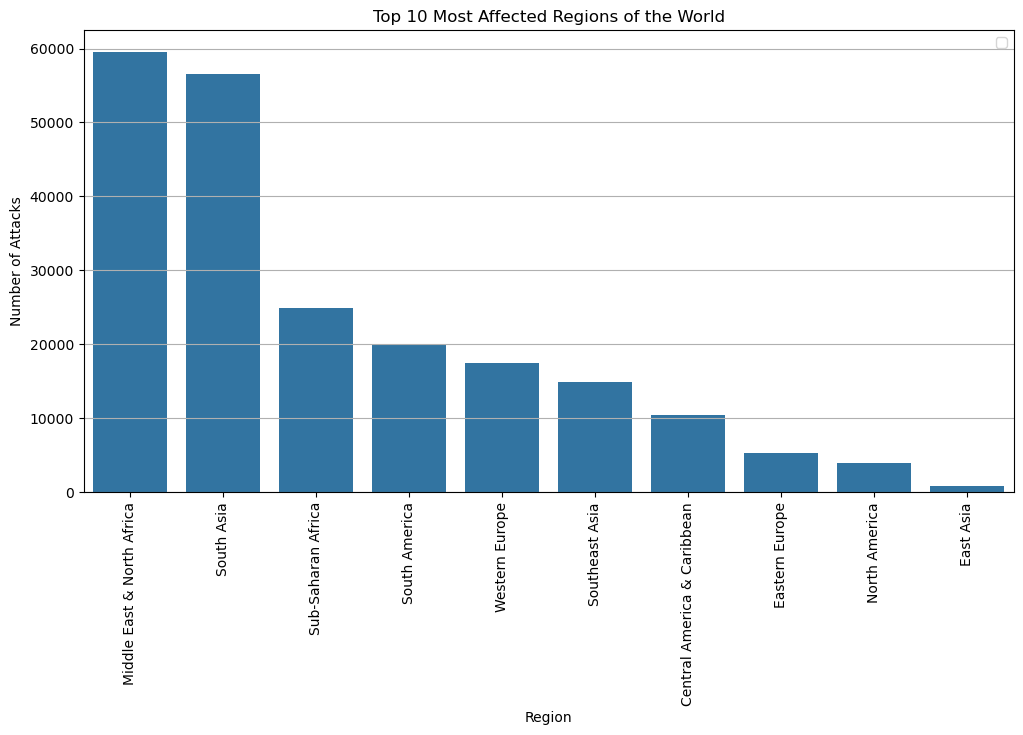

In [98]:
plt.figure(figsize=(12, 6))
# top_10_region.plot(kind='bar')
sns.countplot(data, x='region_txt', order=top_10_region.index)
plt.title('Top 10 Most Affected Regions of the World')
plt.xlabel('Region')
plt.ylabel('Number of Attacks')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.legend()
# plt.savefig("Top10_most_affected_regions_of_world.png", dpi=300, bbox_inches='tight')
plt.show()

# Data Preprocessing

### Check for Duplicates

In [103]:
data.duplicated().sum()

0

In [105]:
# No duplicate values

### Null values check

In [108]:
null_values = data.isnull().sum().sort_values(ascending=False)
null_df = pd.DataFrame(null_values, index=None, columns=['Null Count'])

In [110]:
# Null values greater than zero
greater_than_zero = null_df[null_df['Null Count'] > 0]
null_var = len(greater_than_zero)
print(null_var, 'Variables with Null Values')

104 Variables with Null Values


In [112]:
null_df.reset_index(inplace=True)
null_df = null_df.rename(columns={'index': 'Variables'})
null_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Variables   135 non-null    object
 1   Null Count  135 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.2+ KB


In [114]:
null_df[null_df['Null Count']>0]

,Variables,Null Count
0,gsubname3,214643
1,weapsubtype4,214596
2,weapsubtype4_txt,214596
3,weaptype4,214593
4,weaptype4_txt,214593
...,...,...
99,city,427
100,guncertain1,380
101,ishostkid,178
102,multiple,3


In [116]:
# Calculating percent missing and percent complete
null_df['percent_missing'] = null_df['Null Count']/(len(data))
null_df['percent_complete'] = 1-null_df['percent_missing']

perc_complete = 0.95
selected_attributes = null_df[null_df['percent_complete'] >= perc_complete]
print(len(selected_attributes), f'Attributes have a percent complete >= {int(perc_complete*100)}%')


41 Attributes have a percent complete >= 95%


In [118]:
selected_attributes.reset_index()

,index,Variables,Null Count,percent_missing,percent_complete
0,94,longitude,4727,0.022020,0.977980
1,95,latitude,4726,0.022016,0.977984
2,96,natlty1,2074,0.009662,0.990338
3,97,natlty1_txt,2074,0.009662,0.990338
4,98,target1,637,0.002967,0.997033
5,99,city,427,0.001989,0.998011
6,100,guncertain1,380,0.001770,0.998230
7,101,ishostkid,178,0.000829,0.999171
8,102,multiple,3,0.000014,0.999986
9,103,specificity,1,0.000005,0.999995


In [120]:
selected_attributes_list = selected_attributes['Variables'].to_list()
data_cleaned = data.loc[:, data.columns.isin(selected_attributes_list)]
print(data_cleaned.shape)
print(data_cleaned.columns.values)

(214666, 41)
['eventid' 'iyear' 'imonth' 'iday' 'extended' 'country' 'country_txt'
 'region' 'region_txt' 'provstate' 'city' 'latitude' 'longitude'
 'specificity' 'vicinity' 'crit1' 'crit2' 'crit3' 'doubtterr' 'multiple'
 'success' 'suicide' 'attacktype1' 'attacktype1_txt' 'targtype1'
 'targtype1_txt' 'target1' 'natlty1' 'natlty1_txt' 'gname' 'guncertain1'
 'individual' 'weaptype1' 'weaptype1_txt' 'property' 'ishostkid'
 'dbsource' 'INT_LOG' 'INT_IDEO' 'INT_MISC' 'INT_ANY']


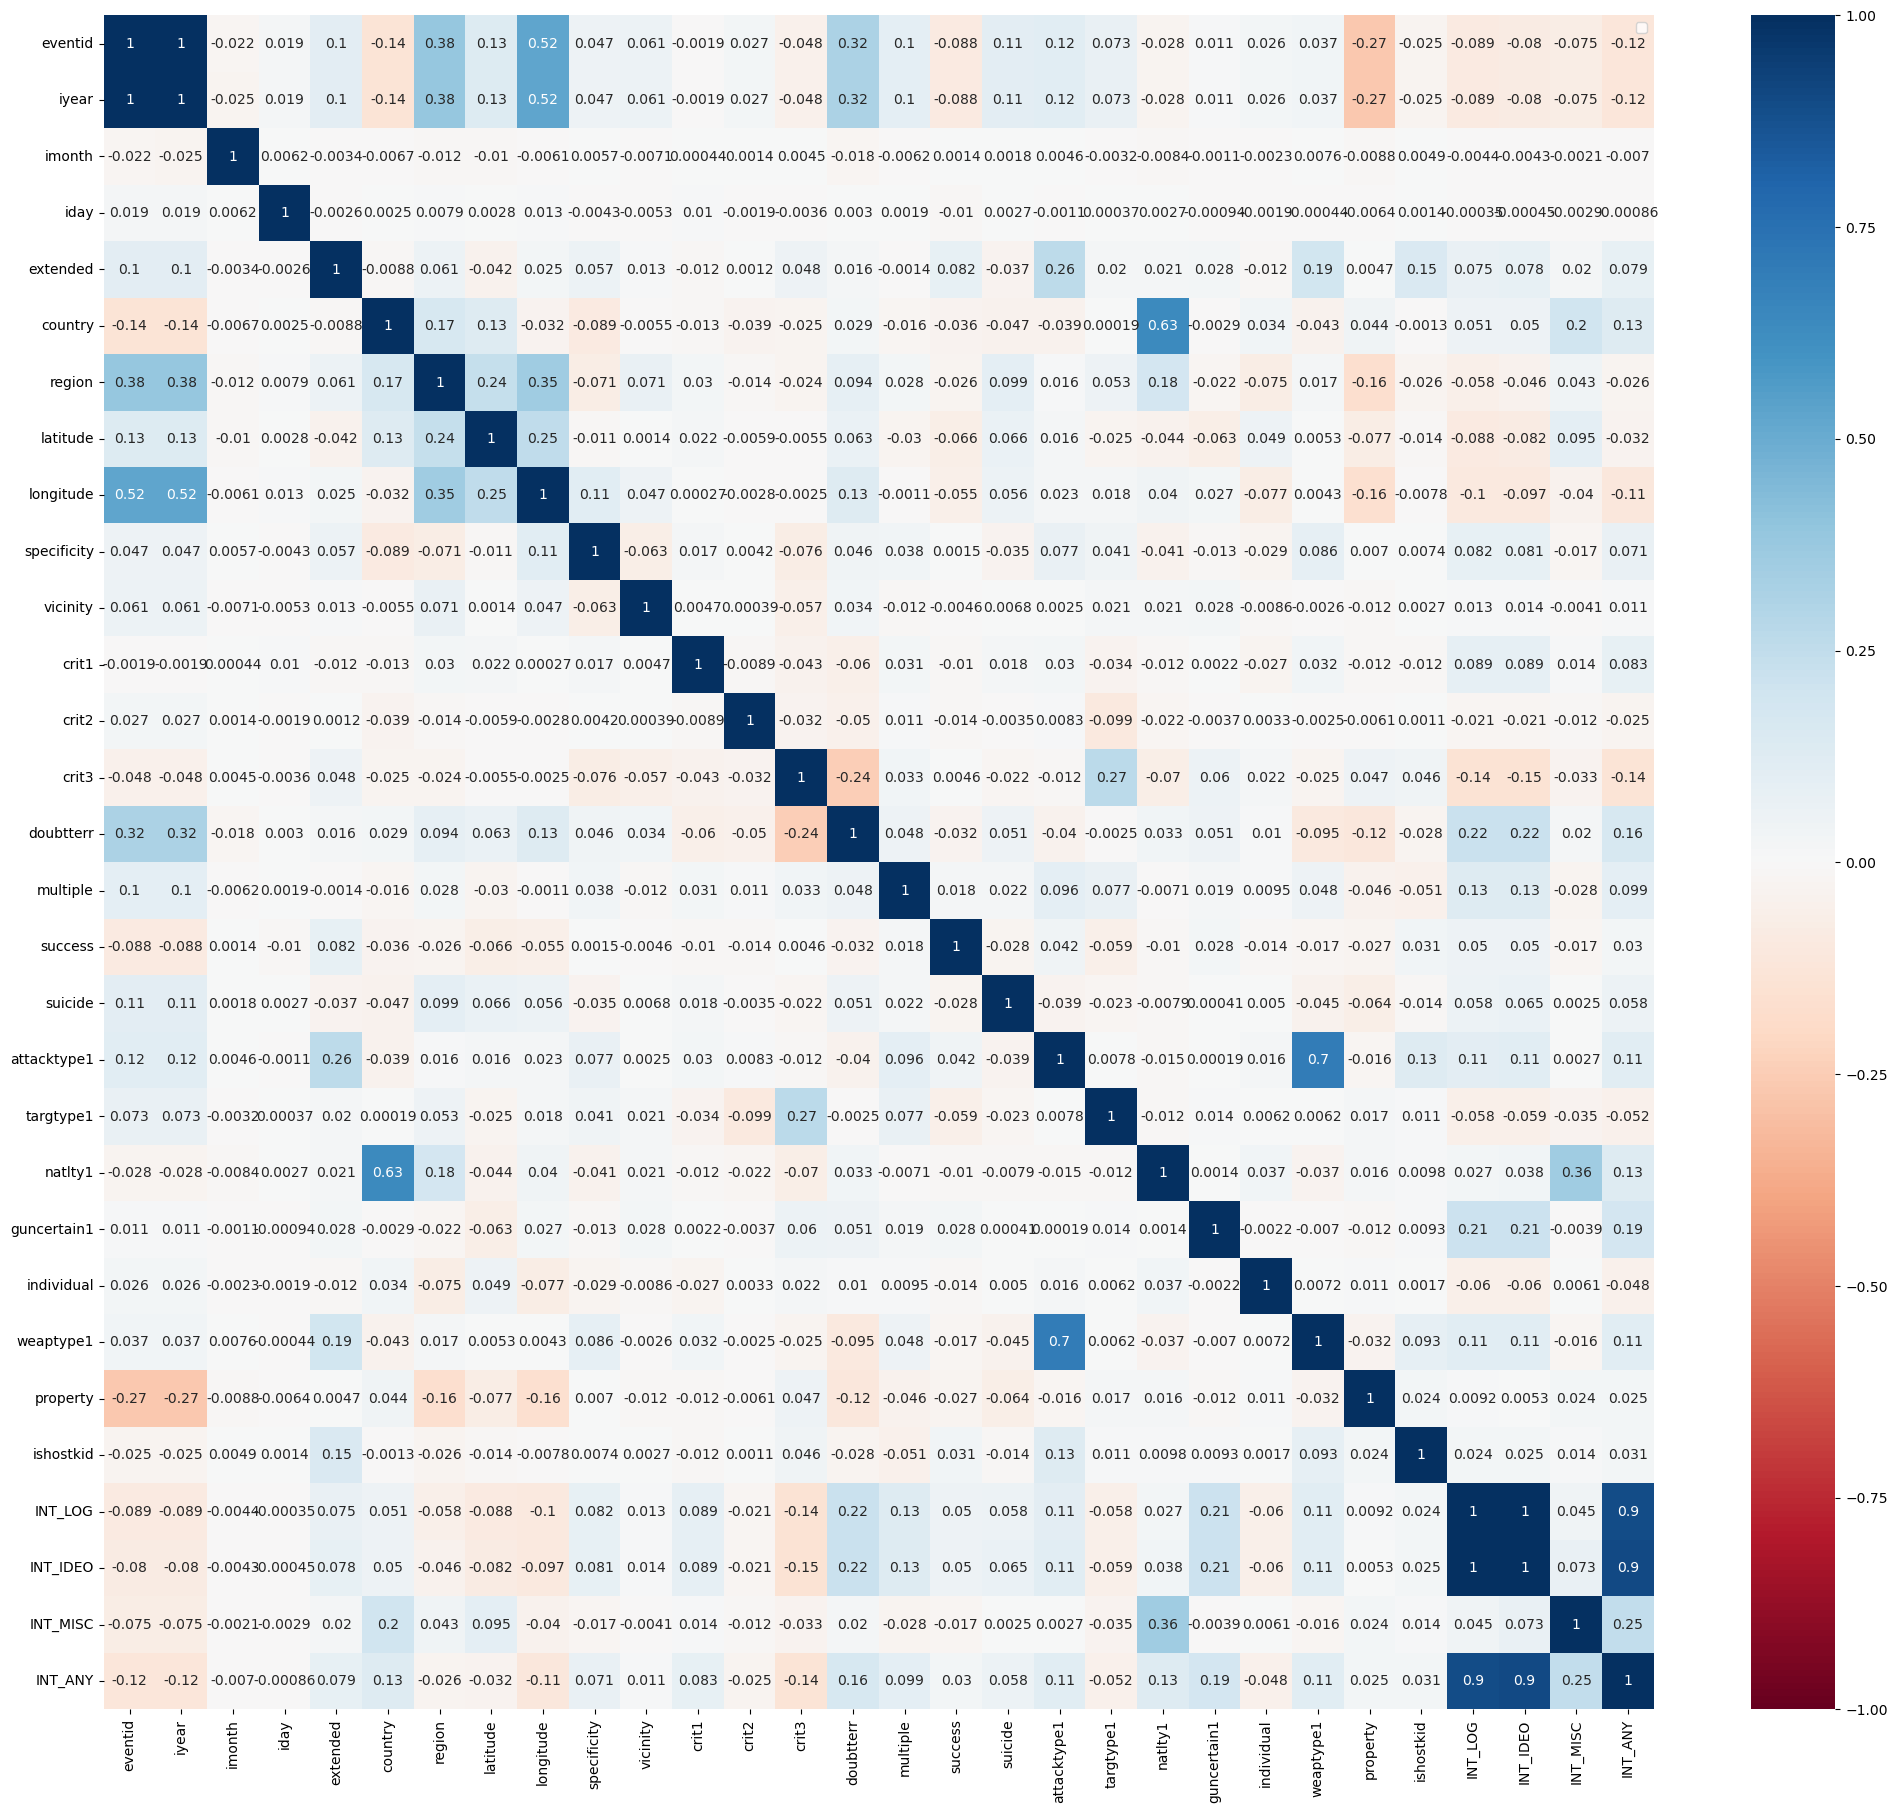

In [124]:
plt.figure(figsize=(25, 22))
sns.heatmap(data_cleaned.corr(numeric_only=True), annot=True, cmap='RdBu', vmin=-1)
plt.legend()
# plt.savefig("Correlation_check.png", dpi=300, bbox_inches='tight')
plt.show()

In [126]:
corr_matrix = data_cleaned.select_dtypes(np.number).corr()

In [128]:
high_corr = corr_matrix.where((corr_matrix > 0.5) & (corr_matrix < 1.0))

high_corr_pairs = high_corr.stack().reset_index()
high_corr_pairs.columns = ['Feature_1', 'Feature_2', 'Correlation']
high_corr_pairs = high_corr_pairs.sort_values(by='Correlation', ascending=False)

print('Highly correlated feature pairs (0.5 < corr < 1.0)')
print(high_corr_pairs)

Highly correlated feature pairs (0.5 < corr < 1.0)
      Feature_1    Feature_2  Correlation
0       eventid        iyear     0.999996
2         iyear      eventid     0.999996
10      INT_LOG     INT_IDEO     0.996426
12     INT_IDEO      INT_LOG     0.996426
13     INT_IDEO      INT_ANY     0.899411
15      INT_ANY     INT_IDEO     0.899411
11      INT_LOG      INT_ANY     0.896726
14      INT_ANY      INT_LOG     0.896726
7   attacktype1    weaptype1     0.698660
9     weaptype1  attacktype1     0.698660
4       country      natlty1     0.634821
8       natlty1      country     0.634821
1       eventid    longitude     0.524264
5     longitude      eventid     0.524264
3         iyear    longitude     0.524248
6     longitude        iyear     0.524248


In [130]:
# Important - Correlation

In [132]:
corr_df = pd.DataFrame(high_corr_pairs)
corr_df.reset_index(inplace=True)

drop_list = set()

for var1, var2 in zip(corr_df['Feature_1'], corr_df['Feature_1']):
    drop_list.add(var1)
    drop_list.add(var2)

drop_list

{'INT_ANY',
 'INT_IDEO',
 'INT_LOG',
 'attacktype1',
 'country',
 'eventid',
 'iyear',
 'longitude',
 'natlty1',
 'weaptype1'}

In [134]:
# Remove correlated columns from the dataset
data_cleaned = data_cleaned.drop(labels=drop_list, axis=1)
data_cleaned.columns

Index(['imonth', 'iday', 'extended', 'country_txt', 'region', 'region_txt',
       'provstate', 'city', 'latitude', 'specificity', 'vicinity', 'crit1',
       'crit2', 'crit3', 'doubtterr', 'multiple', 'success', 'suicide',
       'attacktype1_txt', 'targtype1', 'targtype1_txt', 'target1',
       'natlty1_txt', 'gname', 'guncertain1', 'individual', 'weaptype1_txt',
       'property', 'ishostkid', 'dbsource', 'INT_MISC'],
      dtype='object')

In [136]:
len(data_cleaned.columns)

31

In [138]:
data_cleaned = data_cleaned.drop(labels=['dbsource'], axis=1)

In [141]:
gname_breakdown = data_cleaned.groupby('gname')[['gname']].count().rename(columns={'gname': 'count'})
gname_total = gname_breakdown.index
gname_above_avg = gname_breakdown[gname_breakdown['count'] > gname_breakdown['count'].mean() ]

print('Total Groups: ', len(gname_total))
print('Count of groups responsible for more than the Average attacks: ', len(gname_above_avg))

Total Groups:  3767
Count of groups responsible for more than the Average attacks:  218


In [144]:
# Cut data_cleaned to include only selected groups
gname_above_avg_list = gname_above_avg.index.to_list()
data_cleaned = data_cleaned[data_cleaned['gname'].isin(gname_above_avg_list)]
X_test_final = data_cleaned[data_cleaned['gname']=='Unknown'] # 45% 

In [146]:
# View info on target after removal
gname_breakdown = data_cleaned.groupby(['gname'])[['gname']].count().rename(columns={'gname':'count'})
gname_total = gname_breakdown.index

In [148]:
print('Total groups in new dataset: ', len(gname_total))
print('\n', 'Total number of records after processing: ', len(data_cleaned))

Total groups in new dataset:  218

 Total number of records after processing:  198005


In [150]:
gname_breakdown = data_cleaned.groupby('gname')[['gname']].count().rename(columns={'gname': 'count'})
gname_breakdown

,count
gname,
Abu Sayyaf Group (ASG),595
Adan-Abyan Province of the Islamic State,57
African National Congress (South Africa),607
Al-Aqsa Martyrs Brigade,178
Al-Gama'at al-Islamiyya (IG),259
...,...
United Liberation Front of Assam (ULFA),394
United Popular Action Movement,109
United Self Defense Units of Colombia (AUC),68


In [152]:
# Remove records where gname is 'Unknown'
# Cut data_cleaned 
g_list = gname_breakdown.index.to_list()
g_list.remove('Unknown')

In [154]:
data_cleaned = data_cleaned[data_cleaned['gname'].isin(g_list)]
print("Total number of records after removing 'unknown' groups: ", len(data_cleaned))

Total number of records after removing 'unknown' groups:  104330


## Handle Categorical Variables

In [158]:
# view levels of each categorical variable
    # Only those with levels <30 will be included (ensures python doesn't crash in OneHotEncoding)

cat_vars = data_cleaned.loc[:, data_cleaned.dtypes == object]
cat_vars_count = cat_vars.nunique()
cat_vars_count

country_txt          147
region_txt            12
provstate           1464
city               29028
attacktype1_txt        9
targtype1_txt         22
target1            43178
natlty1_txt          173
gname                217
weaptype1_txt         11
dtype: int64

In [160]:
# After Remove the Unknown Group column, now we have 217 total groups left

In [162]:
# For Rest of the Variables like country_txt, weapontype1_txt, natlty1_txt,
# We are going to use Label Encoding.
# Since, There are too many categories in rest of the columns like provstate, city, target1, we are going to drop those columns

In [164]:
data_cleaned = data_cleaned.drop(labels=['provstate', 'city', 'target1'], axis=1)


## Drop records with null values

In [167]:
data_cleaned.isnull().sum()

imonth                0
iday                  0
extended              0
country_txt           0
region                0
region_txt            0
latitude           2855
specificity           0
vicinity              0
crit1                 0
crit2                 0
crit3                 0
doubtterr             0
multiple              1
success               0
suicide               0
attacktype1_txt       0
targtype1             0
targtype1_txt         0
natlty1_txt         810
gname                 0
guncertain1         374
individual            0
weaptype1_txt         0
property              0
ishostkid            63
INT_MISC              0
dtype: int64

In [169]:
data_cleaned = data_cleaned.dropna()
data_cleaned.shape

(100249, 27)

In [172]:
data_cleaned.columns.values

array(['imonth', 'iday', 'extended', 'country_txt', 'region',
       'region_txt', 'latitude', 'specificity', 'vicinity', 'crit1',
       'crit2', 'crit3', 'doubtterr', 'multiple', 'success', 'suicide',
       'attacktype1_txt', 'targtype1', 'targtype1_txt', 'natlty1_txt',
       'gname', 'guncertain1', 'individual', 'weaptype1_txt', 'property',
       'ishostkid', 'INT_MISC'], dtype=object)

In [174]:
X_test_final.isnull().sum()

imonth                0
iday                  0
extended              0
country_txt           0
region                0
region_txt            0
provstate             0
city                330
latitude           1330
specificity           0
vicinity              0
crit1                 0
crit2                 0
crit3                 0
doubtterr             0
multiple              2
success               0
suicide               0
attacktype1_txt       0
targtype1             0
targtype1_txt         0
target1             232
natlty1_txt        1164
gname                 0
guncertain1           2
individual            0
weaptype1_txt         0
property              0
ishostkid            33
INT_MISC              0
dtype: int64

In [176]:
X_test_final = X_test_final.dropna()
X_test_final = X_test_final.drop(labels=['provstate', 'city', 'target1'], axis=1)
X_test_final.shape

(90668, 27)

In [178]:
X_test_final.head()

,imonth,iday,extended,country_txt,region,region_txt,latitude,specificity,vicinity,crit1,...,targtype1,targtype1_txt,natlty1_txt,gname,guncertain1,individual,weaptype1_txt,property,ishostkid,INT_MISC
2,1,0,0,Philippines,5,Southeast Asia,15.478598,4.0,0,1,...,10,Journalists & Media,United States,Unknown,0.0,0,Unknown,0,0.0,1
3,1,0,0,Greece,8,Western Europe,37.997490,1.0,0,1,...,7,Government (Diplomatic),United States,Unknown,0.0,0,Explosives,1,0.0,1
4,1,0,0,Japan,4,East Asia,33.580412,1.0,0,1,...,7,Government (Diplomatic),United States,Unknown,0.0,0,Incendiary,1,0.0,1
7,1,2,0,United States,1,North America,37.791927,1.0,0,1,...,21,Utilities,United States,Unknown,0.0,0,Explosives,1,0.0,0
12,1,8,0,Italy,8,Western Europe,41.890961,1.0,0,1,...,6,Airports & Aircraft,United States,Unknown,0.0,0,Firearms,0,0.0,1


In [182]:
# One Hot Encoding - Dummy Encoding

In [184]:
columns = ['region_txt', 'attacktype1_txt', 'targtype1_txt', 'weaptype1_txt'] # cols having categories < 30

In [186]:
df_encoded = pd.get_dummies(data_cleaned, columns=columns, drop_first=True, dtype=int)
df_encoded.shape

(100249, 73)

In [188]:
X_test_encoded = pd.get_dummies(X_test_final, columns=columns, drop_first=True, dtype=int)
X_test_encoded.shape

(90668, 74)

In [190]:
missing_cols = [col for col in X_test_encoded.columns if col not in df_encoded.columns]
print("Columns in X_test_encoded but not in df_encoded:\n", missing_cols)

Columns in X_test_encoded but not in df_encoded:
 ['weaptype1_txt_Radiological']


In [192]:
X_test_encoded = X_test_encoded.drop(columns=missing_cols)

In [194]:
X_test_encoded.shape

(90668, 73)

In [201]:
# Ordinal Encoding Variables with more than 30 categories (High Cardinality)
# natlty1_txt, country_txt , Since these are relevent columns for prediction

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

cols = ['country_txt', 'natlty1_txt']
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
df_encoded[cols] = oe.fit_transform(df_encoded[cols].astype(str))
X_test_encoded[cols] = oe.transform(X_test_encoded[cols].astype(str))


## Modeling

In [204]:
# Splitting data into independent and dependent variables
x = df_encoded.drop(columns=['gname'])
y = df_encoded['gname']

In [206]:
# Splitting data usingt train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)

# Train and Test Shape
print('Training Data: x=%s, y=%s ' % (x_train.shape, y_train.shape))
print('Test Data: x=%s, y=%s' % (x_test.shape, y_test.shape))

Training Data: x=(80199, 72), y=(80199,) 
Test Data: x=(20050, 72), y=(20050,)


## Base Model - LogisticRegression

In [210]:
from sklearn.linear_model import LogisticRegression

In [212]:
model_lr = LogisticRegression()
model_lr.fit(x_train, y_train)

LogisticRegression()

In [214]:
ypred_h_lr = model_lr.predict(x_test)
ypred_s_lr = model_lr.predict_proba(x_test)[:, 1]

In [216]:
accuracy_lr = accuracy_score(y_test, ypred_h_lr)
recall_lr = recall_score(y_test, ypred_h_lr, average='weighted')
precision_lr = precision_score(y_test, ypred_h_lr, average='weighted')

print(f'Accuracy Score LR: {accuracy_lr}')
print(f'Recall Score LR: {recall_lr}')
print(f'Precision Score LR: {precision_lr}')

Accuracy Score LR: 0.5234912718204489
Recall Score LR: 0.5234912718204489
Precision Score LR: 0.3866180640354865


## DecisionTreeClassifier

In [221]:
model_dt = DecisionTreeClassifier(random_state=2)
model_dt.fit(x_train, y_train)

DecisionTreeClassifier(random_state=2)

In [223]:
ypred_h_dt = model_dt.predict(x_test)
ypred_s_dt = model_dt.predict_proba(x_test)[:, 1]

In [225]:
accuracy_dt = accuracy_score(y_test, ypred_h_dt)
recall_dt = recall_score(y_test, ypred_h_dt, average='weighted')
precision_dt = precision_score(y_test, ypred_h_dt, average='weighted')

print(f'Accuracy Score LR: {accuracy_dt}')
print(f'Recall Score LR: {recall_dt}')
print(f'Precision Score LR: {precision_dt}')

Accuracy Score LR: 0.7809476309226933
Recall Score LR: 0.7809476309226933
Precision Score LR: 0.7856895695217953


In [227]:
feature_imp = pd.DataFrame({'importances':model_dt.feature_importances_}, index=x_train.columns.to_list()).sort_values(by='importances', ascending=False)
feature_imp[feature_imp['importances'] > 0].head(12)

,importances
latitude,0.312675
country_txt,0.252271
iday,0.061354
imonth,0.047210
region_txt_Middle East & North Africa,0.029979
region_txt_Sub-Saharan Africa,0.025011
targtype1,0.023730
region_txt_Central America & Caribbean,0.018916
doubtterr,0.017026
region_txt_Southeast Asia,0.016779


In [229]:
print(classification_report(y_test, ypred_h_dt))

                                                               precision    recall  f1-score   support

                                       Abu Sayyaf Group (ASG)       0.77      0.68      0.72       125
                     Adan-Abyan Province of the Islamic State       0.62      0.71      0.67         7
                     African National Congress (South Africa)       0.98      0.98      0.98       123
                                      Al-Aqsa Martyrs Brigade       0.28      0.27      0.27        37
                                 Al-Gama'at al-Islamiyya (IG)       0.92      0.92      0.92        52
                                               Al-Islah Party       0.12      0.13      0.13        15
                                              Al-Nusrah Front       0.45      0.48      0.46        61
                                                     Al-Qaida       0.29      0.33      0.31        18
                                             Al-Qaida in Iraq       0.65

## RandomForestClassifier

In [233]:
model_rf = RandomForestClassifier(n_estimators=200, random_state=2)
model_rf.fit(x_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=2)

In [235]:
ypred_h_rf = model_rf.predict(x_test)

In [236]:
accuracy_rf = accuracy_score(y_test, ypred_h_rf)
recall_rf = recall_score(y_test, ypred_h_rf, average='weighted')
precision_rf = precision_score(y_test, ypred_h_rf, average='weighted')

print(f'Accuracy Score LR: {accuracy_rf}')
print(f'Recall Score LR: {recall_rf}')
print(f'Precision Score LR: {precision_rf}')

Accuracy Score LR: 0.816708229426434
Recall Score LR: 0.816708229426434
Precision Score LR: 0.8080266821490387


In [239]:
# grid_rf = {'n_estimators': [200, 300], 
#            'max_depth': [12, 14], 
#            'min_samples_split': [2, 5],
#            'min_samples_leaf': [1, 2]}

# gscv_rf = GridSearchCV(estimator=RandomForestClassifier(), 
#                        param_grid=grid_rf, 
#                        scoring='accuracy', 
#                        cv=10, 
#                        n_jobs=-1)
# gscv_rf.fit(x_train, y_train)

In [241]:
# best_estimator = gscv_rf.best_estimator_
# best_score = gscv_rf.best_score_
# best_params = gscv_rf.best_params_

# print('Best Score : ', best_score)
# print('Best Params: \n', best_params)

## Creating a Metrics DataFrame for the Models

In [246]:
# Initialize an empty list to collect all model metrics
metrics = []

# Define a helper function to evaluate and store metrics
def evaluate_model(name, y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred, average='weighted') # weighted: accounts for class imbalance (more realistic for many datasets).
    precision = precision_score(y_true, y_pred, average='weighted') 
    
    metrics.append({
        'Model': name,
        'Accuracy': round(accuracy, 4),
        'Recall': round(recall, 4),
        'Precision': round(precision, 4)
    })

# Assuming you already have the following predictions:
# y_pred_lr        => Logistic Regression predictions
# y_pred_dt        => Decision Tree predictions
# y_pred_rf        => Random Forest predictions
# y_test           => True values

# Evaluate and store metrics
evaluate_model("Logistic Regression", y_test, ypred_h_lr)
evaluate_model("Decision Tree", y_test, ypred_h_dt)
evaluate_model("Random Forest", y_test, ypred_h_rf)

# Convert to DataFrame
metrics_df = pd.DataFrame(metrics)

# Display metrics
print(metrics_df)

                 Model  Accuracy  Recall  Precision
0  Logistic Regression    0.5235  0.5235     0.3866
1        Decision Tree    0.7809  0.7809     0.7857
2        Random Forest    0.8167  0.8167     0.8080


## Predicting Unknown gnames using Test Data

In [250]:
ypred_h_fin = model_rf.predict(X_test_encoded.drop(columns=['gname']))

In [251]:
ypred_h_fin.shape

(90668,)

In [254]:
X_test_encoded['Predicted_gnames'] = ypred_h_fin

## Final predictions on the test data using RandomForestModel

In [258]:
X_test_encoded['Predicted_gnames'].value_counts()

Predicted_gnames
Islamic State of Iraq and the Levant (ISIL)    20359
Tehrik-i-Taliban Pakistan (TTP)                 7120
Taliban                                         6463
Separatists                                     2616
New People's Army (NPA)                         2274
                                               ...  
Resistenza                                         2
Southern Mobility Movement (Yemen)                 2
Jabha East Africa                                  2
Al-Qaida                                           1
Al-Islah Party                                     1
Name: count, Length: 217, dtype: int64

## Unsupervised Learning

### Step 1: Data Preperation
- 'country_txt' → as the key grouping feature (you will later aggregate on this).
- Numerical / binary features like:
    - 'imonth', 'iday', 'extended', 'region', 'latitude', 'longitude', 'specificity', 'vicinity', 'crit1', 'crit2', 'crit3', 'doubtterr', 'multiple', 'success', 'suicide', 'targtype1', 'natlty1_txt', 'guncertain1', 'individual', 'property', 'ishostkid'
- Encoded variables: 'attacktype1_txt (encoded)', 'targettype1_txt (encoded)', 'weapontype1_txt (encoded)'

### Step 2: Remove or Handle
- Remove or handle:

- Highly correlated or redundant columns.

- Irrelevant ones for country-level insights (e.g., exact date or GPS coordinates can be excluded unless spatial clustering is your goal).

- Text columns that aren’t encoded.

###  Step 3: Aggregate Data by Country
- We’ll aggregate the original DataFrame (df_encoded) to get one row per country, summarizing the key stats.

### Step 4: Normalization
- Clustering works better when features are scaled.

In [528]:
# Group by 'country_txt' and compute relevant metrics
country_agg = df_encoded.groupby('country_txt').agg(
    total_attacks=('country_txt', 'count'),
    successful_attacks=('success', 'sum'),
    suicide_attacks=('suicide', 'sum'),
    property_damage=('property', 'sum'),
    hostage_cases=('ishostkid', 'sum'),
    doubtful_cases=('doubtterr', 'sum'),
    gun_use_cases=('guncertain1', 'sum'),
    individual_attacks=('individual', 'sum'),
    multiple_attacks=('multiple', 'sum'),
).reset_index()

In [532]:
country_agg.sort_values(by='total_attacks', ascending=False).head()

,country_txt,total_attacks,successful_attacks,suicide_attacks,property_damage,hostage_cases,doubtful_cases,gun_use_cases,individual_attacks,multiple_attacks
0,0.0,7540,6757,776,-8307,246.0,1172.0,1101.0,0,1374.0
91,91.0,6327,5681,27,-3144,912.0,-3852.0,1831.0,0,966.0
95,95.0,5742,4905,1225,-9703,470.0,1092.0,541.0,0,2030.0
61,61.0,5530,5158,2,1699,904.0,-1781.0,1040.0,0,828.0
137,137.0,4862,4626,0,3748,174.0,290.0,347.0,0,1065.0


In [537]:
from sklearn.preprocessing import StandardScaler

# Exclude the 'country_txt' column from scaling
features = country_agg.drop('country_txt', axis=1)

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Create a DataFrame for clustering input
X_cluster = pd.DataFrame(scaled_features, columns=features.columns)
X_cluster['country_txt'] = country_agg['country_txt'].values  # Keep for reference

## Step 4: Apply PCA + KMeans Clustering

In [540]:
from sklearn.decomposition import PCA

# Apply PCA to reduce dimensions to 2 (for visualization)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster.drop('country_txt', axis=1))

# Create a DataFrame for PCA output
X_pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
X_pca_df['country_txt'] = X_cluster['country_txt'].values

In [542]:
# Determine Optimal Clusters (Elbow Method)

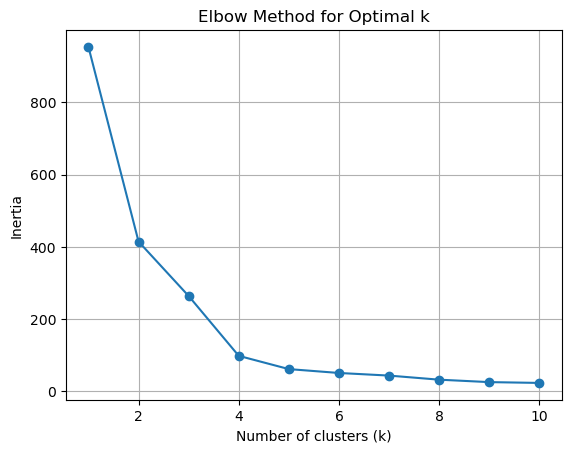

In [546]:
from sklearn.cluster import KMeans

inertia = []
n_clus = range(1, 11)

for k in n_clus:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca_df[['PC1', 'PC2']])
    inertia.append(kmeans.inertia_)

# Plot the Elbow Graph
plt.plot(n_clus, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

In [549]:
# According to the graph, we can take the optimal number of clusters as k=4

### Step 5: Apply KMeans Clustering

In [551]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
X_pca_df['Cluster'] = kmeans.fit_predict(X_pca_df[['PC1', 'PC2']])

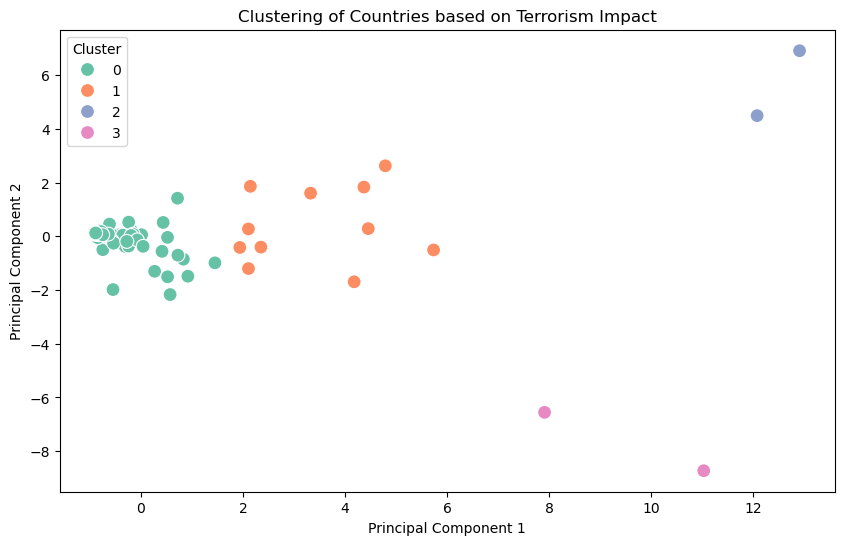

In [553]:
# Visualize Clusters
plt.figure(figsize=(10,6))
sns.scatterplot(data=X_pca_df, x='PC1', y='PC2', hue='Cluster', palette='Set2', s=100)
plt.title('Clustering of Countries based on Terrorism Impact')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

In [555]:
# View Clustered countries

In [557]:
# See which countries belong to each cluster
for i in range(kmeans.n_clusters):
    print(f"\nCluster {i}:")
    print(X_pca_df[X_pca_df['Cluster'] == i]['country_txt'].values)


Cluster 0:
[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  13.  14.  15.
  16.  17.  18.  20.  21.  22.  23.  24.  26.  27.  28.  29.  30.  32.
  33.  34.  35.  36.  38.  39.  40.  41.  43.  44.  45.  46.  47.  48.
  49.  50.  51.  52.  53.  54.  55.  56.  57.  58.  59.  60.  62.  63.
  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.  75.  76.  77.  78.
  79.  80.  81.  82.  83.  84.  85.  86.  87.  88.  89.  90.  92.  93.
  94.  96.  97.  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108.
 109. 110. 111. 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122.
 123. 124. 125. 126. 127. 128. 130. 131. 133. 134. 135. 136. 139. 140.]

Cluster 1:
[ 12.  19.  25.  31.  37.  42.  74. 129. 132. 137. 138.]

Cluster 2:
[ 0. 95.]

Cluster 3:
[61. 91.]


In [559]:
# Step 1: Merge Clusters with Original Aggregated Data

In [561]:
# Merge original aggregated features with cluster labels
clustered_df = X_cluster.merge(X_pca_df[['country_txt', 'Cluster']], on='country_txt')


In [563]:
# Step 2: Analyze Cluster-Wise Mean Values

In [574]:
# Group by cluster and compute mean
cluster_impact = clustered_df.groupby('Cluster')[[
    'total_attacks',
    'successful_attacks',
    'suicide_attacks',
    'property_damage',
    'hostage_cases',
    'doubtful_cases',
    'gun_use_cases',
    'individual_attacks',
    'multiple_attacks'
]].mean().reset_index()

cluster_impact

,Cluster,total_attacks,successful_attacks,suicide_attacks,property_damage,hostage_cases,doubtful_cases,gun_use_cases,individual_attacks,multiple_attacks
0,0,-0.296548,-0.298899,-0.179873,0.143991,-0.228855,-0.041387,-0.255707,0.001668,-0.272741
1,1,1.803595,1.850638,0.701226,-0.462630,0.960274,1.079389,1.341151,0.036525,1.581390
2,2,4.654465,4.500339,7.576397,-6.180413,2.449379,2.394789,3.078090,-0.152996,5.675793
3,3,4.108258,4.151821,-0.101142,-0.346571,6.686954,-5.724072,5.655097,-0.152996,2.809258


In [576]:
# Step 3: Create a Combined "Impact Score"

In [578]:
cluster_impact['impact_score'] = (
    cluster_impact['total_attacks'] +
    cluster_impact['suicide_attacks'] +
    cluster_impact['hostage_cases'] +
    cluster_impact['property_damage']
)

In [580]:
#  Step 4: Identify Most Affected Cluster

In [584]:
# Sort clusters by impact
most_affected = cluster_impact.sort_values(by='impact_score', ascending=False)

print("Most Affected Cluster:")
most_affected.head(1)

Most Affected Cluster:


,Cluster,total_attacks,successful_attacks,suicide_attacks,property_damage,hostage_cases,doubtful_cases,gun_use_cases,individual_attacks,multiple_attacks,impact_score
3,3,4.108258,4.151821,-0.101142,-0.346571,6.686954,-5.724072,5.655097,-0.152996,2.809258,10.347498


In [586]:
# Step 5: List Countries in the Most Affected Cluster

In [588]:
# Extract the cluster ID
most_impacted_cluster_id = most_affected.iloc[0]['Cluster']

# Show countries in that cluster
affected_countries = clustered_df[clustered_df['Cluster'] == most_impacted_cluster_id]['country_txt'].values

print(f"\nCountries in the most affected cluster (Cluster {int(most_impacted_cluster_id)}):")
print(affected_countries)



Countries in the most affected cluster (Cluster 3):
[61. 91.]


In [590]:
# Visualise Cluster impact

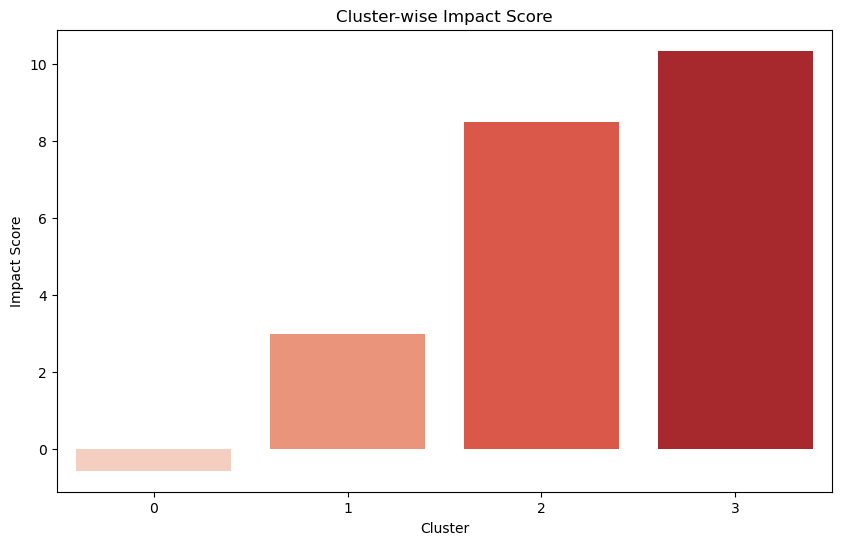

In [592]:
plt.figure(figsize=(10,6))
sns.barplot(data=cluster_impact, x='Cluster', y='impact_score', palette='Reds')
plt.title("Cluster-wise Impact Score")
plt.ylabel("Impact Score")
plt.xlabel("Cluster")
plt.show()